In [1]:
from glob import glob
import os
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize 
import numpy as np

In [20]:
def extract_features(chunk, sr):   
    S = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128)
    chroma = librosa.feature.chroma_stft(S=np.abs(librosa.stft(S, n_fft=256)), sr=sr)
    mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
    # mfcc_delta = librosa.feature.delta(mfcc)
    # mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # flat_S = S.flatten()
    flat_chroma = chroma.flatten()
    flat_mfcc = mfcc.flatten()
    # flat_mfcc_delta = mfcc_delta.flatten()
    # flat_mfcc_delta2 = mfcc_delta2.flatten()
    
    # features = np.hstack((flat_S, flat_chroma, flat_mfcc, flat_mfcc_delta, flat_mfcc_delta2))

    
    features = np.hstack((flat_chroma, flat_mfcc))
    
    return features

In [15]:
def norm_get_feats(files):
    feats = []
    for f in files:
        y, sr = librosa.load(f, sr=44100)
        y = librosa.util.normalize(y)
        feats.append(extract_features(y,sr))
    return feats

In [42]:
def cluster_features(features):
    
    # Apply K-means clustering
    n_clusters = 4  # Specify number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    
    # Initialize lists to store chunk indices for each cluster
    cluster_indices = [[] for _ in range(n_clusters)]
    
    # Collect chunk indices for each cluster
    for chunk_index, label in enumerate(cluster_labels):
        cluster_indices[label].append(chunk_index)
    
    # Convert lists to numpy arrays if needed
    cluster_indices = [np.array(indices) for indices in cluster_indices]
    
    # Print cluster indices
    for i, indices in enumerate(cluster_indices):
        print(f"Cluster {i}: Chunks = {indices}")

    return cluster_indices

In [26]:
np.array(features).shape

(8470, 4203)

In [38]:
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=4,

        random_state=0,

        whiten='unit-variance')

X_transformed = transformer.fit_transform(features)

X_transformed.shape

(8470, 4)

In [32]:
X_transformed[0].shape

(7,)

In [17]:
os.chdir('C:\\Users\Alec\Desktop\SIT_acoustic\ESCAPE_FORMAT_ONECHANNEL\DADSONLY_NEW')

In [18]:
files = glob('d308*')

In [21]:
features = norm_get_feats(files)

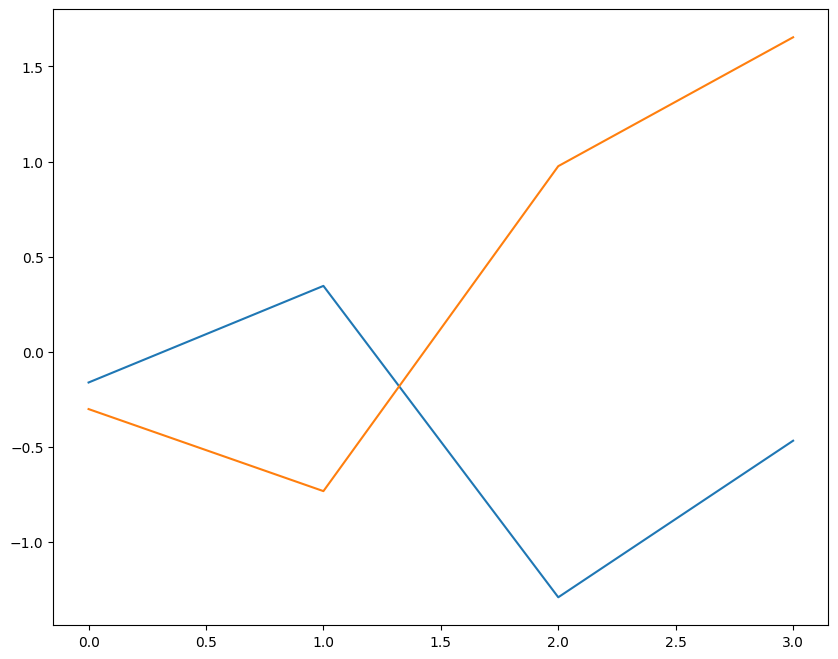

In [39]:
plt.figure(figsize=(10, 8))

plt.plot(X_transformed[1])
plt.plot(X_transformed[1050])
plt.show()

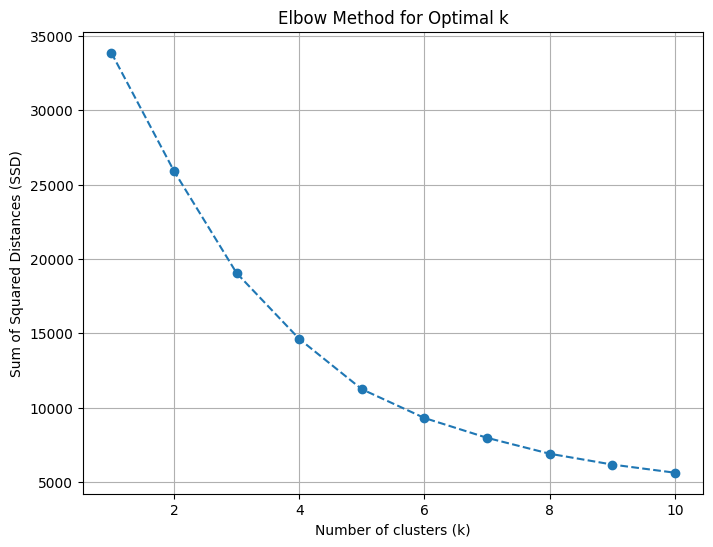

In [40]:
ssd = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_transformed)
    ssd.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), ssd, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [43]:
clusterIdx = cluster_features(X_transformed)

Cluster 0: Chunks = [   1   10   12 ... 8427 8428 8429]
Cluster 1: Chunks = [   0    2    3 ... 8467 8468 8469]
Cluster 2: Chunks = [ 300  301  302 ... 8187 8190 8200]
Cluster 3: Chunks = [4608 4609 4610 4611 4612 4613 4614 4615 4616 4617 4619 4620 4621 4622
 4623 4624 4625 4626 4627 4628 4630 4631 4632 4633 4634 4635 4636 4637
 4638 4639 4641 4642 4643 4644 4645 4646 4647 4648 4649 4650 4652 4653
 4654 4655 4656 4657 4658 4659 4660 4661 4663 4664 4665 4666 4667 4668
 4669 4670 4671 4672 4674 4675 4676 4677 4678 4679 4680 4681 4682 4683
 4685 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027 5028
 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041 5042
 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055 5056
 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069 5070
 5071 5072 5073 5074 5075]


In [143]:
data = []

# Populate the list with file names and their corresponding cluster indices
for cluster_index, indices in enumerate(clusterIdx):
    for idx in indices:
        data.append((files[idx], cluster_index))

# Create a DataFrame from the list
df = pd.DataFrame(data, columns=['File Name', 'Cluster Index'])

# Write DataFrame to an Excel file
excel_file = 'C:\\Users\Alec\Desktop\clustered_files.xlsx'  # Specify the Excel file name/path
df.to_excel(excel_file, index=False)

print(f"DataFrame successfully written to {excel_file}")

DataFrame successfully written to C:\Users\Alec\Desktop\clustered_files.xlsx


In [139]:
import re

In [144]:
excel_file = 'C:\\Users\Alec\Desktop\clustered_files.xlsx' 
output_excel_file = r'C:\Users\Alec\Desktop\clustered_files_sorted.xlsx'  # Output Excel file path

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)

# Function to extract the numeric part of the chunk number
def extract_chunk_number(filename):
    # Extract the last part of the filename before the extension
    filename_without_ext = re.sub(r'\.wav$', '', filename)
    # Search for the last occurrence of 'chunk' followed by digits
    match = re.search(r'chunk(\d+)$', filename_without_ext)
    if match:
        return int(match.group(1))
    else:
        return 0  # Return 0 or another default value if no chunk number found

# Apply the function to create a new column 'Chunk Number'
df['Chunk Number'] = df['File Name'].apply(extract_chunk_number)

# Sort DataFrame by 'File Name' and 'Chunk Number'
df_sorted = df.sort_values(by=['File Name', 'Chunk Number'])

# Drop the 'Chunk Number' column if it's no longer needed
df_sorted.drop(columns=['Chunk Number'], inplace=True)

# Write the sorted DataFrame to Excel
df_sorted.to_excel(output_excel_file, index=False)


print(f"Data has been written to {output_excel_file}")

Data has been written to C:\Users\Alec\Desktop\clustered_files_sorted.xlsx
